In [44]:
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

to_rgb = lambda image: cv.cvtColor(image, cv.COLOR_BGR2RGB)
to_gray = lambda image: cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [146]:
board = cv.imread('../data/board+dominoes/01.jpg', cv.IMREAD_COLOR)

In [151]:
# https://theailearner.com/tag/cv2-getperspectivetransform/
big = np.array([[164, 666], [2892, 604], [3013, 3348], [196, 3465]], dtype=np.float32)
small = np.array([[592, 1063], [2491, 1019], [2572, 2948], [629, 3020]], dtype=np.float32)

inputs = big

dist = 0
for i in range(len(inputs)):
    a, b = inputs[i], inputs[(i+1)%len(inputs)]
    dist = max(dist, np.linalg.norm(a-b))

dist = int(dist)
dist

2819

In [152]:
output = np.array([[0, 0], [dist - 1, 0], [dist - 1, dist - 1], [0, dist - 1]], dtype=np.float32)

M = cv.getPerspectiveTransform(inputs,output)
out = cv.warpPerspective(board,M,(dist, dist),flags=cv.INTER_LINEAR)

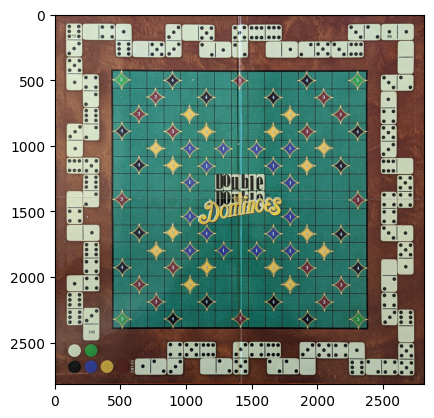

In [153]:
plt.imshow(to_rgb(out))

In [154]:
cv.imwrite('../data/board+dominoes/01_template_outer.jpg', out)

True

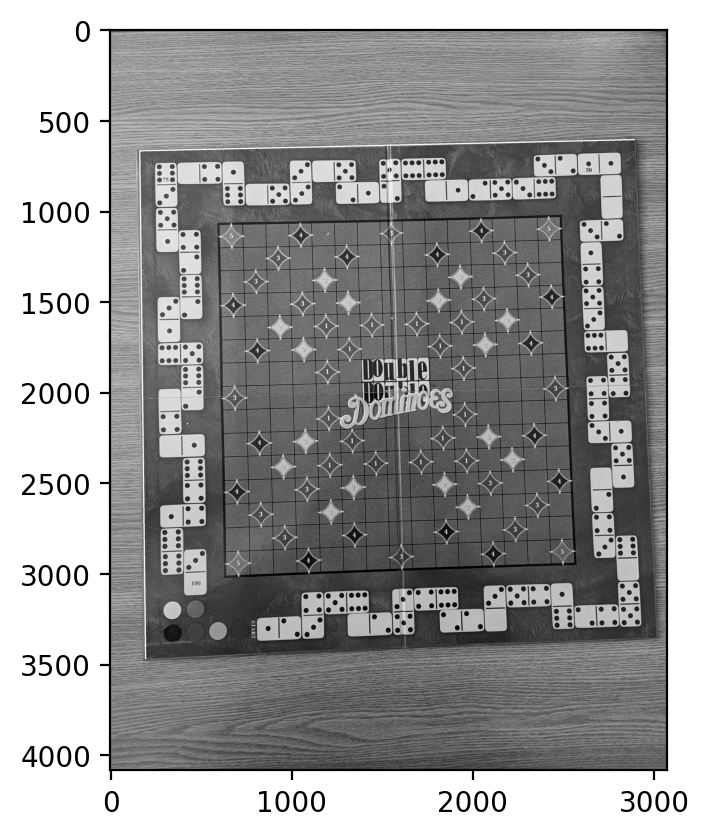

In [126]:
temp = cv.line(board, big[0], big[1], (255, 255, 255), 5)
temp = cv.line(board, big[0], big[3], (255, 255, 255), 5)

plt.figure(dpi=200)
plt.imshow(board, cmap='gray')

In [391]:
query = cv.imread('../data/test_outputs/processed_board_(6_07).jpg', cv.IMREAD_COLOR)
query_gray = to_gray(query)

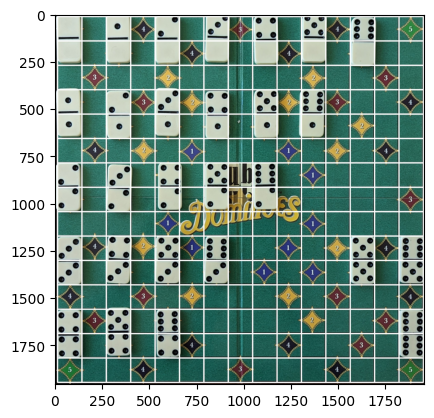

In [392]:
# query = cv.imread('../data/test_outputs/processed_board_(8_09).jpg', cv.IMREAD_COLOR)
plt.imshow(to_rgb(query))

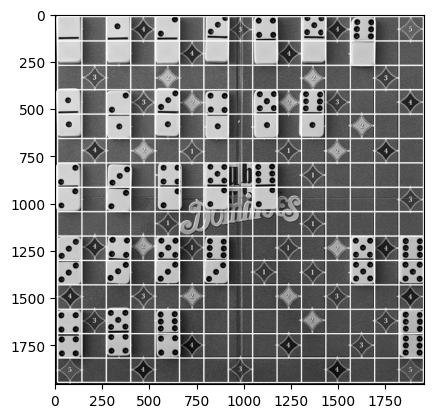

In [393]:
plt.imshow(query_gray, cmap='gray')

In [185]:
query_rescaled = cv.resize(query_gray, None, fx=0.5, fy=0.5)
template_rescaled = cv.resize(template_gray, None, fx=0.5, fy=0.5)

query_image_edges = cv.Canny( b,255/3,255)
template_image_edges =  cv.Canny(template_rescaled,255/3,255)

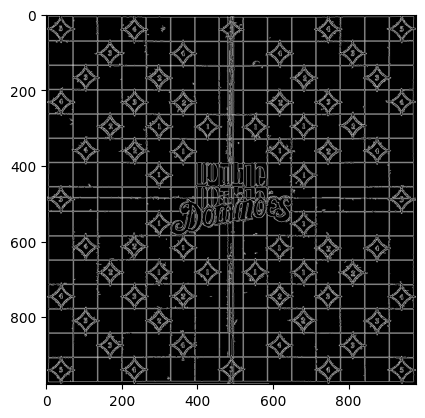

In [186]:
plt.imshow(template_image_edges, cmap='gray')

In [187]:
def mean_ssd(image_1, image_2) -> float:
    """
     This function receives two matrices having the same dimension and returns the mean of squared differences them.
    :param image_1. The first matrix
    :param image_2. The second matrix
    :return float. The mean of squared differences.
    """ 
    image_1 = np.float32(image_1)  
    image_2 = np.float32(image_2)  
    return np.mean((image_1 - image_2) ** 2)
 

def get_displacement_vector(img_query, img_template, window_i: tuple = (-30, 30), window_j: tuple = (-30, 30)) -> tuple: 
    """
    It returns (pos_i, pos_j) which is the best alignment of img_query to img_template.
    :param img_query. This is the query image that will be alligned to the template.
    :param img_tempalte. this is the template
    :window_i:tuple. The start and end position on the y axis.
    :window_j:tuple. The start and end position on the x axis.
    :return (pos_i, pos_j) which is the best alignment of img_query to img_template
    """
    pos_i = 0; pos_j = 0
    min_error = np.inf
    height_1, width_1 = img_query.shape        
    height_blue, width_blue = img_template.shape
    
    for i in range(window_i[0], window_i[1]):
        for j in range(window_j[0], window_j[1]):   
            if i >= 0:
                ymin_blue = i
                ymax_blue = height_blue
                ymin_1 = 0
                ymax_1 = height_1 - i
            else:
                ymin_blue = 0
                ymax_blue = height_blue + i
                ymin_1 = -i
                ymax_1 = height_1
               
            if j >= 0:
                xmin_blue = j
                xmax_blue = width_blue
                xmin_1 = 0
                xmax_1 = width_1 - j
            else:
                xmin_blue = 0
                xmax_blue = width_blue + j
                xmin_1 = -j
                xmax_1 = width_1
                
            patch_1 = img_query[ymin_1: ymax_1, xmin_1: xmax_1]
            patch_2 = img_template[ymin_blue: ymax_blue, xmin_blue: xmax_blue]   
            
            assert patch_1.shape == patch_2.shape
                
            value = mean_ssd(patch_1, patch_2) 
            if min_error > value:
                min_error = value
                pos_i = i
                pos_j = j   
    return pos_i, pos_j

  
def allign_image_based_on_displacement_vector(image_, pos_i, pos_j):
    """
    Receive the image and the displacement vector and reconstruct the image according to the  displacement vector.
    """
    window_size = max(np.abs([pos_i, pos_j]))
    height, width = image_.shape  
    allign_image = 255 * np.ones((height + window_size * 2, width + window_size * 2), np.uint8) 
    allign_image[pos_i + window_size: pos_i + window_size + height,
                 pos_j + window_size: pos_j + window_size + width] = image_.copy()

    return allign_image

In [188]:
query_image_edges.shape, template_image_edges.shape

((978, 978), (978, 978))

In [189]:
pos_i, pos_j = get_displacement_vector(query_image_edges, template_image_edges)
alligned_image = allign_image_based_on_displacement_vector(query_rescaled, pos_i, pos_j)

In [190]:
print(pos_i, pos_j)

0 0


In [191]:
cv.imwrite('alligned.jpg', alligned_image)

True

In [192]:
cv.imwrite('query.jpg', query_rescaled)

True

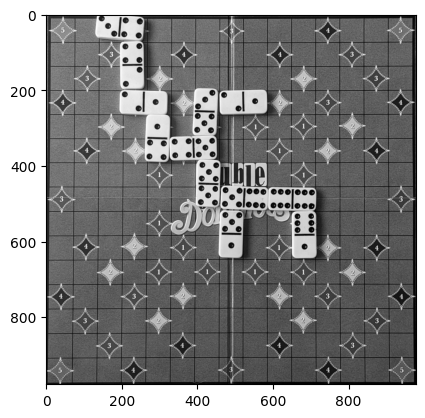

In [193]:
plt.imshow(alligned_image, cmap='gray')

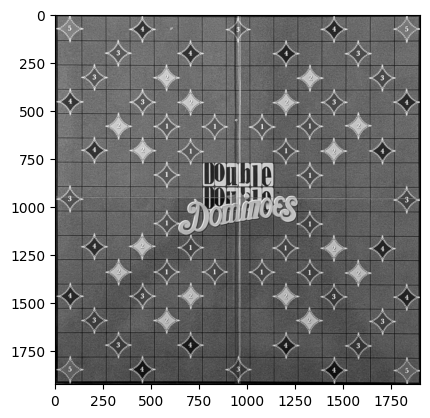

In [55]:
plt.imshow(template_gray, cmap='gray')

In [395]:
board = query_gray #to_gray(cv.imread('../data/board+dominoes/01.jpg', cv.IMREAD_COLOR))

In [398]:
blur = cv.GaussianBlur(board, (3, 3), 0)
_, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inverted = cv.bitwise_not(thresh, thresh)
kernel = np.ones((5, 5), dtype=np.uint8)
dilation = cv.dilate(inverted,kernel,iterations = 1)
output=dilation.copy()
circles = cv.HoughCircles(output, cv.HOUGH_GRADIENT_ALT, 1, 10, 
                          param1=300, param2=0.80, 
                          minRadius=10, 
                          maxRadius=1)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    print(len(circles))
    for (x, y, r) in circles:
        cv.circle(output, (x, y), r, (128, 128, 128), -1)

2


False
119


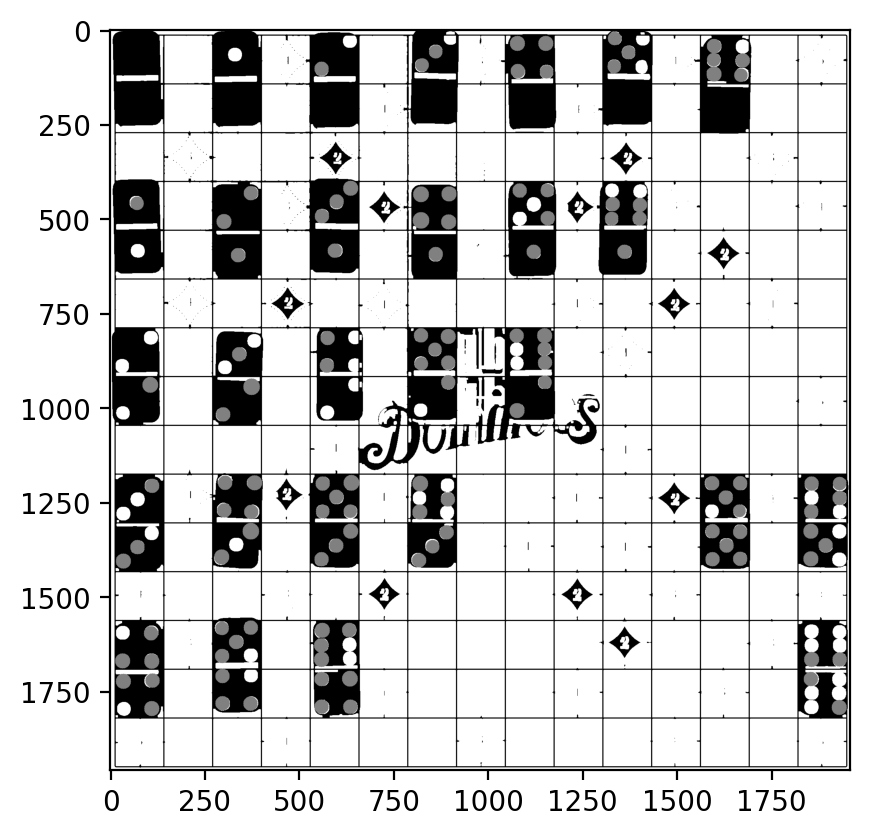

In [3]:
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

to_rgb = lambda image: cv.cvtColor(image, cv.COLOR_BGR2RGB)
to_gray = lambda image: cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.figure(dpi=200)

query = cv.imread('../data/test_outputs/processed_board_(6_07).jpg', cv.IMREAD_COLOR)
query_gray = to_gray(query)

board=query_gray.copy()
blur = cv.GaussianBlur(board, (3, 3), 0)
_, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inverted = cv.bitwise_not(thresh, thresh)

kernel = np.ones((5, 5), dtype=np.uint8)

dilation = cv.dilate(inverted,kernel,iterations = 1)

# kernel = np.ones((3, 3), dtype=np.uint8)

# edges = cv.Canny(dilation,255/3,255, apertureSize=3)

# erosion = cv.erode(dilation,kernel,iterations = 1)

# opening = cv.morphologyEx(dilation, cv.MORPH_OPEN, kernel)

# closing = cv.morphologyEx(dilation, cv.MORPH_CLOSE, kernel)

output=dilation.copy()
circles = cv.HoughCircles(output, cv.HOUGH_GRADIENT_ALT, 1, 10, 
                          param1=200, param2=0.90, 
                          minRadius=10, 
                          maxRadius=105
                         )

print(circles is None)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    print(len(circles))
    for (x, y, r) in circles:
        cv.circle(output, (x, y), r, (128, 128, 128), -1)
#         print(x,y,r)


# plt.subplot(2, 2, 1)
# plt.imshow(dilation, cmap='gray')

# plt.subplot(2, 2, 2)
plt.imshow(output, cmap='gray')

# plt.subplot(2, 2, 3)
# plt.imshow(edges, cmap='gray')

# plt.subplot(2, 2, 4)
# plt.imshow(edges_inverted, cmap='gray')

In [215]:
import imblurred = cv.GaussianBlur(board, (5, 5), 3)
thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)utils

In [219]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


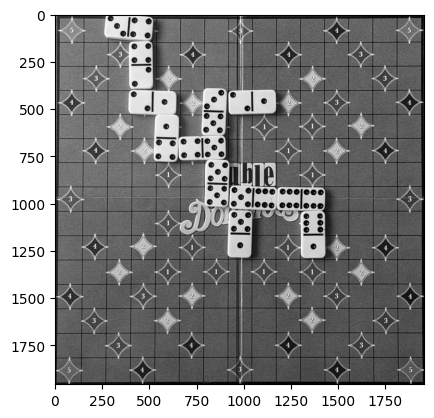

In [216]:
plt.imshow(board, cmap='gray')

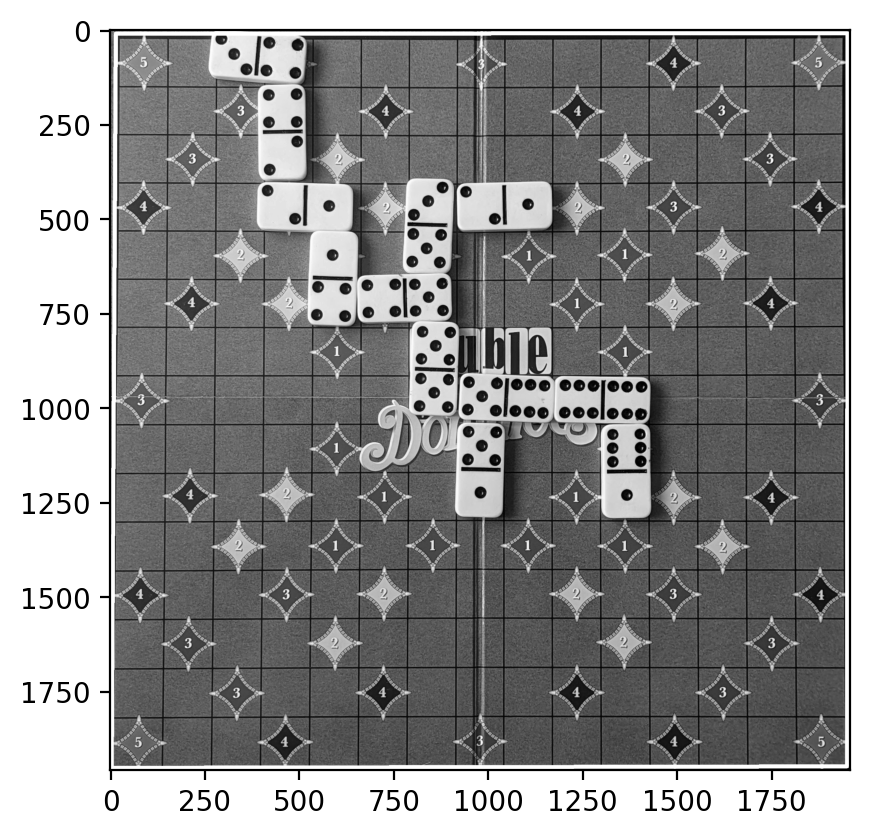

In [217]:
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv.contourArea, reverse=True)

i = 0
bc = board.copy()

poly=None
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        poly = approx
        cv.drawContours(bc, [poly], -1, (255, 255, 255), 10)
        break
        
plt.figure(dpi=200)
plt.imshow(bc, cmap='gray')

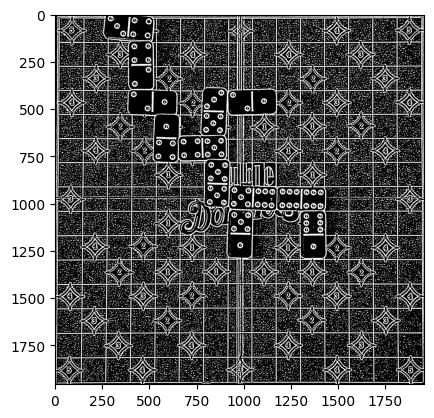

In [218]:
plt.imshow(thresh, cmap='gray')